# Serial Peripheral Interface Example

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pioemu import clock_cycles_reached, emulate, State
from adafruit_pioasm import Program
from collections import deque

## Introduction

This notebook demonstrates the emulation of a PIO program for the Raspberry Pi Foundation's RP2040 Microcontroller. The PIO program is a SPI transciever

## PIO Program

Below is the PIO program that will be emulated. Try changing it and observing the results!

In [2]:
asm = Program('''
; Adapted from https://github.com/raspberrypi/pico-examples/blob/master/pio/spi/spi.pio
; Copyright (c) 2020 Raspberry Pi (Trading) Ltd.
; SPDX-License-Identifier: BSD-3-Clause
; This program implement full-duplex SPI, with a SCK period of 2 clock cycles.

.program spi_cpha0
.side_set 1

; Pin assignments:
; - SCK is side-set pin 2
; - MOSI is OUT pin 0
; - MISO is IN pin 0
;
; Autopush and autopull must be enabled, and the serial frame size is set by
; configuring the push/pull threshold. Shift left/right is fine, but you must
; justify the data yourself. This is done most conveniently for frame sizes of
; 8 or 16 bits by using the narrow store replication and narrow load byte
; picking behaviour of RP2040's IO fabric.

; Clock phase = 0: data is captured on the leading edge of each SCK pulse, and
; transitions on the trailing edge, or some time before the first leading edge.

    out pins, 1 side 0 ; Output on falling edge
    in pins, 1  side 1 ; Input on rising edge
''')

program = asm.assembled
print(program)
print(asm.pio_kwargs)

array('H', [24577, 20481])
{'sideset_enable': False, 'sideset_pin_count': 1}


## Emulation

In [3]:
class Clocked:
    def __init__(self, data,bits):
        self.data = data
        self.i = bits
        self.prev = 0
    def next(self, state:State) -> int:
        clk = state.pin_values & 4
        if clk and not self.prev:
            self.i -= 1
        self.prev = clk
        mask = 1<<self.i if self.i>=0 else 0
        return 1 if self.data & mask else 0

tx_bytes = [0x13,0x76,0x56,0x9A]
init = State(transmit_fifo=deque([x<<24 | x<<16 | x<<8 | x for x in tx_bytes]), #narrow store replication
                                 pin_directions=0x06)

pin_value_series = [
    (state.clock, state.pin_values, state.receive_fifo.pop() if state.receive_fifo else None)
    for _, state in emulate(program, stop_when=clock_cycles_reached(32 + 1),
                            initial_state = init,
                            input_source=Clocked(0x96F1,15).next, 
                            auto_pull=True, 
                            auto_push=True, 
                            pull_threshold=8, 
                            push_threshold=8,
                            shift_isr_right=False,
                            shift_osr_right=False,
                            side_set_base=2, 
                            side_set_count=asm.pio_kwargs['sideset_pin_count'],
                            out_base=1,
                            out_count=1,
                            #wrap_target=asm.pio_kwargs['wrap_target'],
                            #wrap_top=asm.pio_kwargs['wrap_top'],
                           )
]

## Signal timings

This represents the view seen by the PIO.
MISO appears to be delayed by one clock cycle because this is when the state machine *samples* the input data, even though the new data would have been available at the pins shortly after the SCK edge.

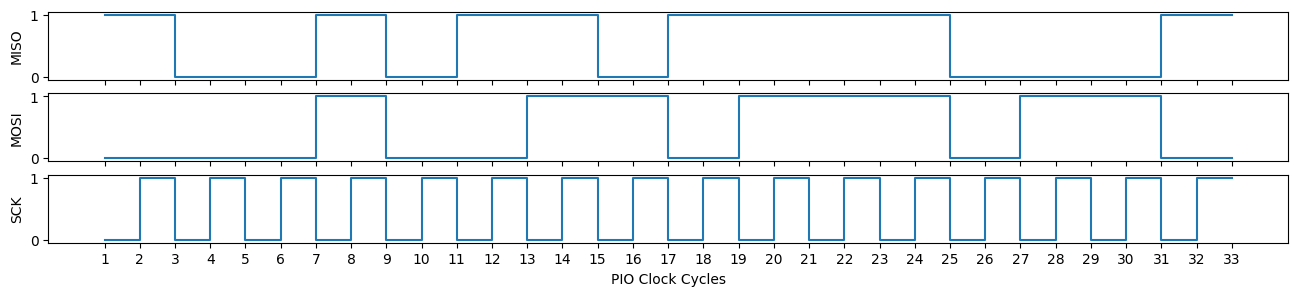

In [4]:
t = [clock for clock, _, _ in pin_value_series]
def binary_plot(names):
    n = len(names)
    fig, axes = plt.subplots(n,1,sharex=True,sharey=True, figsize=(16,3))
    try:
        axes[0]
    except:
        axes = [axes]
    for i in range(n):
        axes[i].step(t,  [1 if x[1]&(1<<i) else 0 for x in pin_value_series])
        axes[i].set_ylabel(names[i])
    axes[-1].set_xlabel('PIO Clock Cycles')
    plt.yticks([0,1])
    plt.xticks(t)

binary_plot(['MISO','MOSI','SCK'])

# Received Data

In [5]:
[hex(b) for _,_,b in pin_value_series if b is not None]

['0x96', '0xf1']